In [1]:
# %%
import pickle
import os
from sklearn.cluster import KMeans
from scipy.cluster.vq import vq
import numpy as np
import pandas as pd


In [2]:
# Load the processed datasets
sift_train = "../data/sift_datasets/train_data.pkl"
sift_test = "../data/sift_datasets/test_data.pkl"

with open(sift_train, "rb") as f:
    x_train, metadata_train = pickle.load(f)

with open(sift_test, "rb") as f:
    x_test, metadata_test = pickle.load(f)


In [3]:
# Function to create histograms for Bag of Words model
def create_histograms1(feature_list, kmeans_model):
    histograms = []
    for features in feature_list:
        words, _ = vq(features, kmeans_model.cluster_centers_)
        hist, _ = np.histogram(
            words, bins=range(kmeans_model.n_clusters + 1), density=True
        )
        histograms.append(hist)
    return histograms


In [4]:
def create_histograms(feature_list, kmeans_model):
    histograms = []
    for features in feature_list:
        # Check if the features array is empty
        if features.size == 0:
            # Assign a zero histogram if there are no features
            hist = np.zeros(kmeans_model.n_clusters)
        else:
            words, _ = vq(features, kmeans_model.cluster_centers_)
            hist, _ = np.histogram(
                words, bins=range(kmeans_model.n_clusters + 1), density=True
            )
        histograms.append(hist)
    return histograms


In [5]:
number_of_visual_words = 50  # You can adjust this number
all_descriptors = []
total_features = len(x_train)
print("Aggregating descriptors...")

for i, feature in enumerate(x_train):
    all_descriptors.extend(feature)
    
    # Print progress every 5% (or choose a different interval if needed)
    if not i % 500:
        print(f"Progress: {i / total_features * 100:.2f}% complete")

print("Aggregation complete.")


Aggregating descriptors...
Progress: 0.00% complete
Progress: 5.33% complete
Progress: 10.67% complete
Progress: 16.00% complete
Progress: 21.33% complete
Progress: 26.66% complete
Progress: 32.00% complete
Progress: 37.33% complete
Progress: 42.66% complete
Progress: 47.99% complete
Progress: 53.33% complete
Progress: 58.66% complete
Progress: 63.99% complete
Progress: 69.33% complete
Progress: 74.66% complete
Progress: 79.99% complete
Progress: 85.32% complete
Progress: 90.66% complete
Progress: 95.99% complete
Aggregation complete.


In [6]:
kmeans_vw = KMeans(n_clusters=number_of_visual_words, random_state=42, verbose=1)
kmeans_vw.fit(all_descriptors)


/uw/.venvs/ml_research/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 136127953278.0.
Iteration 1, inertia 92923454634.95909.
Iteration 2, inertia 91117683754.51216.
Iteration 3, inertia 90460960609.97722.
Iteration 4, inertia 90097547650.33418.
Iteration 5, inertia 89856527730.64975.
Iteration 6, inertia 89675323027.09578.
Iteration 7, inertia 89522578464.67203.
Iteration 8, inertia 89373587845.49915.
Iteration 9, inertia 89221570717.88478.
Iteration 10, inertia 89089288025.96344.
Iteration 11, inertia 88994526760.16449.
Iteration 12, inertia 88929324636.03294.
Iteration 13, inertia 88879715710.6279.
Iteration 14, inertia 88835386745.85657.
Iteration 15, inertia 88794228605.87936.
Iteration 16, inertia 88755861087.60854.
Iteration 17, inertia 88719057512.42021.
Iteration 18, inertia 88684324967.86533.
Iteration 19, inertia 88652291214.67801.
Iteration 20, inertia 88621327050.20146.
Iteration 21, inertia 88590726615.75656.
Iteration 22, inertia 88560743273.54434.
Iteration 23, inertia 88535202707.96663.
Iterat

KMeans(n_clusters=50, random_state=42, verbose=1)

In [7]:
# Step 2: Create histograms for training and testing sets
x_train_histograms = create_histograms(x_train, kmeans_vw)
x_test_histograms = create_histograms(x_test, kmeans_vw)


In [8]:
# Step 3: Apply KMeans Clustering on histograms
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(x_train_histograms)


/uw/.venvs/ml_research/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(random_state=42)

In [9]:
# Predict clusters for the test set
clusters = kmeans.predict(x_test_histograms)


In [10]:
x=3
x

3

In [11]:
# Extracting diagnosis labels from metadata
diagnosis_labels = [metadata["diagnosis"] for metadata in metadata_test]


In [12]:
# Creating a DataFrame for analysis
cluster_vs_diagnosis = pd.DataFrame(
    {"Cluster": clusters, "Diagnosis": diagnosis_labels}
)


In [13]:
# Analyzing the correspondence
correspondence_analysis = (
    cluster_vs_diagnosis.groupby(["Cluster", "Diagnosis"]).size().unstack(fill_value=0)
)
print(correspondence_analysis)

# %%


Diagnosis  actinic keratosis  basal cell carcinoma  dermatofibroma  melanoma  \
Cluster                                                                        
0                          5                    16               4        21   
1                          0                     7               1        65   
2                          0                     0               0         1   
3                          1                    11               5        21   
4                         20                    76              14       156   
5                          0                     1               4         5   
6                          2                     2               1         2   
7                          3                    14               2        13   

Diagnosis  nevus  pigmented benign keratosis  squamous cell carcinoma  \
Cluster                                                                 
0            178                          34         

In [14]:
# Find max values from each row
max_values = correspondence_analysis.max(axis=1)

# Check if max values are unique
unique_max_values = len(max_values) == len(set(max_values))

# Output results
print("Max values from each row:\n", max_values)
print("Each row has a unique max value:", unique_max_values)


Max values from each row:
 Cluster
0    178
1    261
2     88
3    165
4    330
5    135
6    151
7    221
dtype: int64
Each row has a unique max value: True


In [15]:
# Find max values and corresponding diagnosis for each row
max_values_with_labels = correspondence_analysis.idxmax(axis=1)

# Display the results
print("Max diagnosis in each cluster:")
print(max_values_with_labels)


Max diagnosis in each cluster:
Cluster
0    nevus
1    nevus
2    nevus
3    nevus
4    nevus
5    nevus
6    nevus
7    nevus
dtype: object


In [16]:
# Find max values and their counts
max_counts = correspondence_analysis.max(axis=1)
max_diagnoses = correspondence_analysis.idxmax(axis=1)

# Combine the information
max_info = pd.DataFrame({
    "Max Diagnosis": max_diagnoses,
    "Count": max_counts
})

print(max_info)


        Max Diagnosis  Count
Cluster                     
0               nevus    178
1               nevus    261
2               nevus     88
3               nevus    165
4               nevus    330
5               nevus    135
6               nevus    151
7               nevus    221


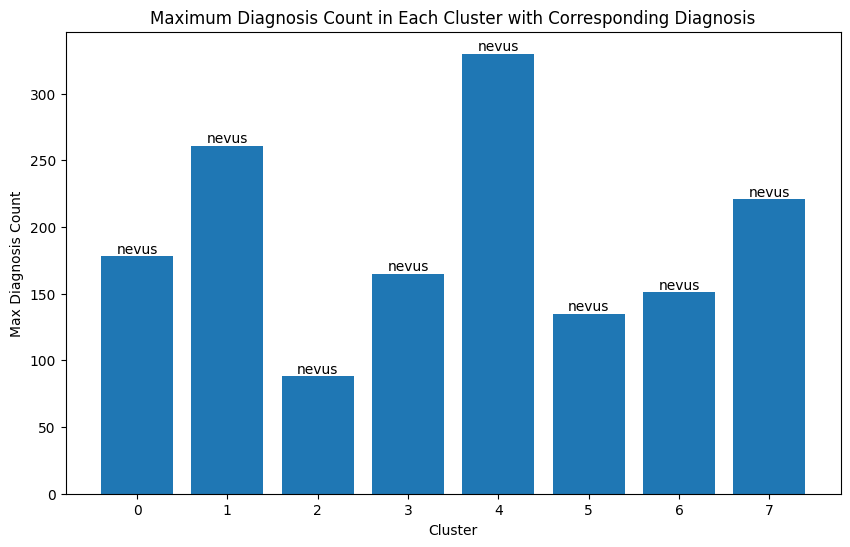

In [17]:
import matplotlib.pyplot as plt

# Create a bar chart
plt.figure(figsize=(10,6))
plt.bar(max_info.index, max_info['Count'])

# Add labels for each bar
for idx, label in enumerate(max_info['Max Diagnosis']):
    plt.text(idx, max_info['Count'][idx], str(label), ha='center', va='bottom')

plt.xlabel('Cluster')
plt.ylabel('Max Diagnosis Count')
plt.title('Maximum Diagnosis Count in Each Cluster with Corresponding Diagnosis')
plt.show()


In [18]:
# Display the count of each diagnosis in each cluster
for cluster_id in correspondence_analysis.index:
    print(f"Cluster {cluster_id}:")
    print(correspondence_analysis.loc[cluster_id].sort_values(ascending=False))
    print()


Cluster 0:
Diagnosis
nevus                         178
pigmented benign keratosis     34
melanoma                       21
basal cell carcinoma           16
squamous cell carcinoma         7
actinic keratosis               5
dermatofibroma                  4
vascular lesion                 3
Name: 0, dtype: int64

Cluster 1:
Diagnosis
nevus                         261
melanoma                       65
pigmented benign keratosis     27
vascular lesion                13
basal cell carcinoma            7
dermatofibroma                  1
actinic keratosis               0
squamous cell carcinoma         0
Name: 1, dtype: int64

Cluster 2:
Diagnosis
nevus                         88
pigmented benign keratosis     2
melanoma                       1
vascular lesion                1
actinic keratosis              0
basal cell carcinoma           0
dermatofibroma                 0
squamous cell carcinoma        0
Name: 2, dtype: int64

Cluster 3:
Diagnosis
nevus                         165
pigme

In [19]:
import cv2
import matplotlib.pyplot as plt

p = "../data/images/"
image_paths = [p + x.isic_id + ".JPG" for x in metadata_test]

# Assuming 'image_paths' is a list of file paths corresponding to your images
# and 'clusters' and 'diagnosis_labels' are as previously defined
image_data = pd.DataFrame({
    'Path': image_paths,
    'Cluster': clusters,
    'Diagnosis': diagnosis_labels
})


In [20]:
cluster_index = 2
max_diagnosis = correspondence_analysis.loc[cluster_index].idxmax()
max_diagnosis

'nevus'

In [21]:
correspondence_analysis


Diagnosis,actinic keratosis,basal cell carcinoma,dermatofibroma,melanoma,nevus,pigmented benign keratosis,squamous cell carcinoma,vascular lesion
Cluster,,,,,,,,
0,5,16,4,21,178,34,7,3
1,0,7,1,65,261,27,0,13
2,0,0,0,1,88,2,0,1
3,1,11,5,21,165,26,2,5
4,20,76,14,156,330,149,24,11
5,0,1,4,5,135,4,0,0
6,2,2,1,2,151,3,0,1
7,3,14,2,13,221,21,1,8


In [1]:
x = 3
x

3

In [22]:

    # # Filter images from the specified cluster with the max diagnosis
    # filtered_images = [img_path for img_path, metadata in zip(image_paths, metadata_test)
    #                    if metadata['Cluster'] == cluster_index and metadata['Diagnosis'] == max_diagnosis]

In [23]:
# import cv2
# import matplotlib.pyplot as plt

# def display_images_from_cluster(cluster_index, num_images=5):
#     # Get the diagnosis with the max value in the specified cluster
#     max_diagnosis = correspondence_analysis.loc[cluster_index].idxmax()

#     # Filter images from the specified cluster with the max diagnosis
#     filtered_images = [img_path for img_path, metadata in zip(image_paths, metadata_test)
#                        if metadata['Cluster'] == cluster_index and metadata['Diagnosis'] == max_diagnosis]

#     # Randomly select a few images to display
#     sample_images = np.random.choice(filtered_images, size=min(num_images, len(filtered_images)), replace=False)

#     # Display the images
#     fig, axs = plt.subplots(1, len(sample_images), figsize=(20, 5))
#     for i, img_path in enumerate(sample_images):
#         img = cv2.imread(img_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert color from BGR to RGB

#         axs[i].imshow(img)
#         axs[i].set_title(f"Cluster {cluster_index} - {max_diagnosis}")
#         axs[i].axis('off')

#     plt.show()

# # Example usage
# display_images_from_cluster(2)  # Replace '2' with the cluster index you want to visualize
